In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import scipy.io as scio 
import scipy.io as sio
import scipy
from tensorflow.python.framework import ops
from matplotlib.colors import ListedColormap   
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report  

In [2]:
def split_data(Labeled_points, Labels, test_size=0.3, random_state=42):
     

    # Set the random seed, if provided
    if random_state is not None:
        np.random.seed(random_state)

    # Get the number of data points
    num_points = Labeled_points.shape[0]

    # Calculate the number of points to use for testing
    num_test = int(num_points * test_size)

    # Shuffle the indices of the data points
    indices = np.random.permutation(num_points)

    # Split the indices into training and testing sets
    test_indices = indices[:num_test]
    train_indices = indices[num_test:]

    # Use the indices to get the training and testing data points and labels
    X_train = Labeled_points[train_indices]
    X_test = Labeled_points[test_indices]
    y_train = Labels[train_indices]
    y_test = Labels[test_indices]

    return X_train, X_test, y_train, y_test

In [3]:
def random_mini_batches_single(x_train_set, y_train_set, minibatch_size, seed=0):
    m = x_train_set.shape[0]  # number of training examples
    np.random.seed(seed)
    # Shuffle the data
    permutation = list(np.random.permutation(m))
    shuffled_x = x_train_set[permutation, :]
    shuffled_y = y_train_set[permutation, :]

    # Partition (shuffled_x, shuffled_y). Minus the end case.
    # number of mini batches of size mini_batch_size in your partitionning
    num_complete_minibatches = m // minibatch_size
    minibatches = []
    for k in range(0, num_complete_minibatches):
        minibatch_x = shuffled_x[k * minibatch_size: k *
                                 minibatch_size + minibatch_size, :]
        minibatch_y = shuffled_y[k * minibatch_size: k *
                                 minibatch_size + minibatch_size, :]
        minibatch = (minibatch_x, minibatch_y)
        minibatches.append(minibatch)

    # Handling the end case (last mini-batch < mini_batch_size)
    if m % minibatch_size != 0:
        minibatch_x = shuffled_x[num_complete_minibatches *
                                 minibatch_size: m, :]
        minibatch_y = shuffled_y[num_complete_minibatches *
                                 minibatch_size: m, :]
        minibatch = (minibatch_x, minibatch_y)
        minibatches.append(minibatch)
    return minibatches

In [4]:
def create_placeholders(n_x, n_y):
   
    isTraining = tf.compat.v1.placeholder_with_default(True, shape=())
    x = tf.compat.v1.placeholder(tf.float32, [None, n_x], name = "x")
    y = tf.compat.v1.placeholder(tf.float32, [None, n_y], name = "Y")

    return x, y, isTraining

In [5]:
def initialize_parameters():

    
    tf.compat.v1.set_random_seed(1)
     
    x_w1 = tf.compat.v1.get_variable("x_w1", [3,3,224,32], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform", seed = 1))
    x_b1 = tf.compat.v1.get_variable("x_b1", [32], initializer = tf.compat.v1.zeros_initializer())

    x_w2 = tf.compat.v1.get_variable("x_w2", [3,3,32,64], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform", seed = 1))
    x_b2 = tf.compat.v1.get_variable("x_b2", [64], initializer = tf.compat.v1.zeros_initializer())
    
    x_w3 = tf.compat.v1.get_variable("x_w3", [1,1,64,128], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform", seed = 1))
    x_b3 = tf.compat.v1.get_variable("x_b3", [128], initializer = tf.compat.v1.zeros_initializer())

    x_w4 = tf.compat.v1.get_variable("x_w4", [1,1,128,12], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform", seed = 1))
    x_b4 = tf.compat.v1.get_variable("x_b4", [12], initializer = tf.compat.v1.zeros_initializer())
    
    parameters = {"x_w1": x_w1,
                  "x_b1": x_b1,
                  "x_w2": x_w2,
                  "x_b2": x_b2,
                  "x_w3": x_w3,
                  "x_b3": x_b3,
                  "x_w4": x_w4,
                  "x_b4": x_b4}

    return parameters

In [6]:
def mynetwork(x, parameters, isTraining, momentums = 0.9):
    x = tf.reshape(x, [-1, 7, 7, 224], name = "x")
        
    with tf.compat.v1.name_scope("x_layer_1"):
         
         x_z1 = tf.nn.conv2d(x, filters=parameters['x_w1'], strides=[1, 1, 1, 1], padding='SAME') + parameters['x_b1'] 
         x_z1_bn = tf.compat.v1.layers.batch_normalization(x_z1, momentum = momentums, training = isTraining)
         x_z1_po = tf.compat.v1.layers.max_pooling2d(x_z1_bn, 2, 2, padding='SAME')
         x_a1 = tf.nn.relu(x_z1_po)
         
    with tf.compat.v1.name_scope("x_layer_2"):
         
         x_z2 = tf.nn.conv2d(x_a1, filters=parameters['x_w2'], strides=[1, 1, 1, 1], padding='SAME') + parameters['x_b2'] 
         x_z2_bn = tf.compat.v1.layers.batch_normalization(x_z2, momentum = momentums, training = isTraining)   
         x_z2_po = tf.compat.v1.layers.max_pooling2d(x_z2_bn, 2, 2, padding='SAME')
         x_a2 = tf.nn.relu(x_z2_po)

    with tf.compat.v1.name_scope("x_layer_3"):
        
         x_z3 = tf.nn.conv2d(x_a2, filters=parameters['x_w3'], strides=[1, 1, 1, 1], padding='SAME') + parameters['x_b3'] 
         x_z3_bn = tf.compat.v1.layers.batch_normalization(x_z3, momentum = momentums, training = isTraining)   
         x_z3_po = tf.compat.v1.layers.max_pooling2d(x_z3_bn, 2, 2, padding='SAME')
         x_a3 = tf.nn.relu(x_z3_po)
         
    with tf.compat.v1.name_scope("x_layer_4"):
        
         x_z4 = tf.nn.conv2d(x_a3, filters=parameters['x_w4'], strides=[1, 1, 1, 1], padding='SAME') + parameters['x_b4'] 
         x_z4_shape = x_z4.get_shape().as_list()
         x_z4_2d = tf.reshape(x_z4, [-1, x_z4_shape[1] * x_z4_shape[2] * x_z4_shape[3]])
       
    l2_loss =   tf.nn.l2_loss(parameters['x_w1']) + tf.nn.l2_loss(parameters['x_w2']) + tf.nn.l2_loss(parameters['x_w3'])\
                + tf.nn.l2_loss(parameters['x_w4'])
               
    return x_z4_2d, l2_loss

In [7]:
def mynetwork_optimaization(y_es, y_re, l2_loss, reg, learning_rate, global_step):
#     print(y_es.shape)
#     print(y_re.shape)
     
    with tf.compat.v1.name_scope("cost"): 
          cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_es, labels = tf.stop_gradient( y_re))) + reg * l2_loss
               
    with tf.compat.v1.name_scope("optimization"):
          update_ops = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
          optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost, global_step=global_step)
          optimizer = tf.group([optimizer, update_ops])
         
    return cost, optimizer

In [8]:
def train_mynetwork(x_train_set, y_train_set, x_test_set, y_test_set, learning_rate_base = 0.001, beta_reg = 0.001, num_epochs = 200, minibatch_size = 32, print_cost = True):
    
    ops.reset_default_graph()                       
    tf.compat.v1.set_random_seed(1)                          
    seed = 1                                    
    (m, n_x) = x_train_set.shape                        
    (m, n_y) = y_train_set.shape                            

    costs = []                                   
    costs_dev = []
    train_acc = []
    val_acc = []
    correct_prediction = 0
    
    # Create Placeholders of shape (n_x, n_y)
    x, y, isTraining = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    with tf.compat.v1.name_scope("network"):

         x_out, l2_loss= mynetwork(x, parameters, isTraining)
         
    global_step = tf.Variable(0, trainable = False)
    learning_rate = tf.compat.v1.train.exponential_decay(learning_rate_base, global_step, 50 * m/minibatch_size, 0.5, staircase = True)
    
    with tf.compat.v1.name_scope("optimization"):
         # network optimization
         cost, optimizer = mynetwork_optimaization(x_out, y, l2_loss, beta_reg, learning_rate, global_step)

    with tf.compat.v1.name_scope("metrics"):
         # Calculate the correct predictions
         joint_layerT = tf.transpose(x_out)
         yT = tf.transpose(y)
         correct_prediction = tf.equal(tf.argmax(joint_layerT), tf.argmax(yT))
         accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

    # Initialize all the variables
    init = tf.compat.v1.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.compat.v1.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs + 1):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            epoch_acc = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches_single(x_train_set, y_train_set, minibatch_size, seed)
            for minibatch in minibatches:

                # Select a minibatch
                (batch_x, batch_y) = minibatch 
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _, minibatch_cost, minibatch_acc = sess.run([optimizer, cost, accuracy], feed_dict={x: batch_x, y: batch_y, isTraining: True})
           
                epoch_cost += minibatch_cost
                epoch_acc += minibatch_acc
                
            epoch_cost_train = epoch_cost / num_minibatches
            epoch_acc_train = epoch_acc / num_minibatches
            
            features, epoch_cost_dev, epoch_acc_dev = sess.run([x_out, cost, accuracy], feed_dict={x: x_test_set, y: y_test_set, isTraining: False})
      
            # Print the cost every epoch
            if print_cost == True and (epoch) % 50 == 0:
                print ("epoch %i: Train_loss: %f, Val_loss: %f, Train_acc: %f, Val_acc: %f" % (epoch, epoch_cost_train, epoch_cost_dev, epoch_acc_train, epoch_acc_dev))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost_train)
                train_acc.append(epoch_acc_train)
                costs_dev.append(epoch_cost_dev)
                val_acc.append(epoch_acc_dev)
        
        # plot the cost      
        plt.plot(np.squeeze(costs), label='Training cost')
        plt.plot(np.squeeze(costs_dev), label='Validation cost')
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.legend()
        plt.show()
        # plot the accuracy 
        plt.plot(np.squeeze(train_acc), label='Training accuracy')
        plt.plot(np.squeeze(val_acc), label='Validation accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.legend()
        plt.show()
         
        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
       
        return parameters, val_acc, features

In [9]:
import numpy as np

def extract_spectral_bands(data, labels):
    n_bands = data.shape[1]
    window_size = 49
    labeled_points = np.where(labels != -1)[0]
    n_labeled = len(labeled_points)
    extracted_data = np.zeros((n_labeled, n_bands * window_size))
    extracted_labels = np.zeros(n_labeled)
    
    for i in range(n_labeled):
        idx = labeled_points[i]
        if idx < window_size:
            window = np.concatenate([data[0:idx+window_size+1,:], np.tile(data[idx+window_size,:], (window_size-idx,1))])
        elif idx >= data.shape[0] - window_size:
            window = np.concatenate([np.tile(data[idx-window_size,:], (window_size-(data.shape[0]-idx)+1,1)), data[idx-window_size:,:]])
        else:
            window = data[idx-window_size:idx+window_size+1,:]
        window = window.reshape(1, -1)  # Reshape window to 2D array with 1 row
        # extracted_data[i,:] = window.flatten()
        extracted_labels[i] = labels[idx]
    
    return extracted_data, extracted_labels


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
epoch 0: Train_loss: 2.772703, Val_loss: 2.530825, Train_acc: 0.182065, Val_acc: 0.142857
epoch 50: Train_loss: 0.514956, Val_loss: 0.524136, Train_acc: 0.843750, Val_acc: 0.853968
epoch 100: Train_loss: 0.309569, Val_loss: 0.384911, Train_acc: 0.913043, Val_acc: 0.898413
epoch 150: Train_loss: 0.218160, Val_loss: 0.326498, Train_acc: 0.956522, Val_acc: 0.904762
epoch 200: Train_loss: 0.152553, Val_loss: 0.311730, Train_acc: 0.979620, Val_acc: 0.901587


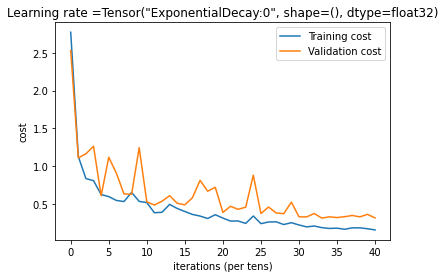

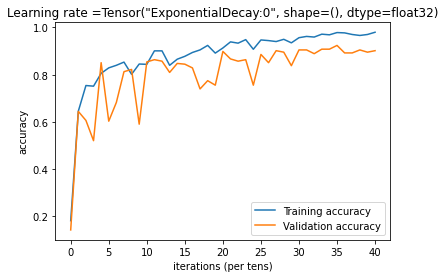

Parameters have been trained!
(315,) (315,)
Confusion Matrix:
 [[16  0  0  0  0  1  0  0  0  0  0  1]
 [ 0 19  1  0  1  0  0  2  0  1  0  0]
 [ 0  0  8  0  0  0  2  0  0  0  0  0]
 [ 0  0  0 10  0  6  0  1  0  0  0  0]
 [ 0  0  0  0 33  0  0  0  2  0  0  0]
 [ 0  0  0  0  0 14  0  0  0  0  0  0]
 [ 1  0  0  1  0  0 10  1  0  0  0  0]
 [ 0  0  1  1  0  0  1 23  0  0  0  0]
 [ 0  0  0  0  0  1  0  1 57  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 43  2  0]
 [ 0  0  0  0  0  0  0  0  0  1 42  0]
 [ 0  0  0  0  0  1  0  0  1  0  0  9]]
Accuracy: 0.9015873015873016
Precision: 0.8753795035124958
Recall: 0.8651731167563033
F1-score: 0.863185148438076
ROC AUC score: 0.9894629704862387


In [10]:
Labeled_points = scipy.io.loadmat('Labeled_Cuprite_Data/data_points_CNN.mat')['data_points']
Labels = scipy.io.loadmat('Labeled_Cuprite_Data/labels.mat')['labels']
Labels = Labels.T
num_classes = 12 
# print(Labeled_points.shape, Labels_onehot.shape)

Cuprite_data = scipy.io.loadmat('Cuprite.mat')
Cuprite_data =Cuprite_data['X']  
Cuprite_data= Cuprite_data.reshape(-1, Cuprite_data.shape[-1]) 
maxVal=np.amax(Cuprite_data)
minVal=np.amin(Cuprite_data) 
Cuprite_shifted = Cuprite_data + abs(minVal) 
Cuprite_norm = Cuprite_shifted / (abs(minVal) + abs(maxVal))
Cuprite_norm = Cuprite_norm + 1e-6  
  
Labels_onehot=tf.keras.utils.to_categorical(Labels, num_classes)


# print(Labeled_points.shape, Labels_onehot.shape)



X_train, X_test, Y_train, Y_test = split_data(Labeled_points, Labels_onehot, test_size=0.3)  

# print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
parameters, val_acc, feature = train_mynetwork(X_train, Y_train, X_test, Y_test) 

y_pred = np.argmax(feature, axis=1)
y_true = np.argmax(Y_test, axis=1) 

print(y_pred.shape, y_true.shape)
# create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# print confusion matrix
print("Confusion Matrix:\n", cm)

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average='macro'))
print("Recall:", recall_score(y_true, y_pred, average='macro'))
print("F1-score:", f1_score(y_true, y_pred, average='macro'))
print("ROC AUC score:", roc_auc_score(Y_test, feature, multi_class='ovr'))